In [1]:
!pip install pyheif

from PIL import Image
import pyheif

from tqdm.notebook import tqdm

from pathlib import Path
from tqdm import tqdm
import numpy as np

import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

import os

from google.colab import drive
drive.mount('/content/drive')

model = torch.hub.load('ПУТЬ К МОДЕЛИ', 'custom', path='ПУТЬ К ВЕСАМ')

clear_output()

In [2]:
import random

def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_all(0)

Здесь изображения загружаются и кладутся в массивы class_0_imgs, class_1_imgs, class_2_imgs в виде объектов PiL.Image, соответствующие здоровым растениям, больным бурой ржавчиной и белой гнилью соответственно. Ячейка скрыта ввиду ограничений на распространение данных.

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import models, transforms as T
from torch.utils.data import Dataset, DataLoader

In [5]:
drive.flush_and_unmount()

In [6]:
# сохранение локально фотографий в формате .jpg по 3м разным директориям, пути к файлам нужны дальше для подачи в модель model(path)
os.mkdir('class0')
os.mkdir('class1')
os.mkdir('class2')

In [7]:
for i, image in enumerate(class_0_imgs):
    image.save('class0/' + str(i) + '.jpg')
for i, image in enumerate(class_1_imgs):
    image.save('class1/' + str(i) + '.jpg')
for i, image in enumerate(class_2_imgs):
    image.save('class2/' + str(i) + '.jpg')

In [8]:
# вычисление предсказаний нахождения симптомов того или иного заболевания
# preds_all[i][j][k] соответствует k-ой предсказанной рамке для j-ой фотографии i-ого класса
# предсказанная рамка - массив [x1, y1, x2, y2, conf, class]
preds_all = [[], [], []]
dirs = ['class0', 'class1', 'class2']
imgs_lens = [len(class_0_imgs), len(class_1_imgs), len(class_2_imgs)]
for j, dir in enumerate(dirs):
    inds = np.arange(imgs_lens[j])
    inds1 = inds[ : len(inds) // 100 * 100].reshape((-1, 100))
    inds2 = inds[len(inds) // 100 * 100:]
    for k in range(inds1.shape[0]):
        imgs = [dir + '/' + str(num) + '.jpg' for num in inds1[k]]
        preds = model(imgs).pred
        for i in range(len(preds)):
            preds[i] = preds[i].cpu()
        preds_all[j] += preds
    imgs = [dir + '/' + str(num) + '.jpg' for num in inds2]
    preds = model(imgs).pred
    for i in range(len(preds)):
        preds[i] = preds[i].cpu()
    preds_all[j] += preds

In [9]:
lens = []
for i, preds_per_class in enumerate(preds_all):
    for j, pred in enumerate(preds_per_class):
        lens += [pred.shape[0]]
print(np.max(lens))

192


In [25]:
import warnings
warnings.filterwarnings("ignore")

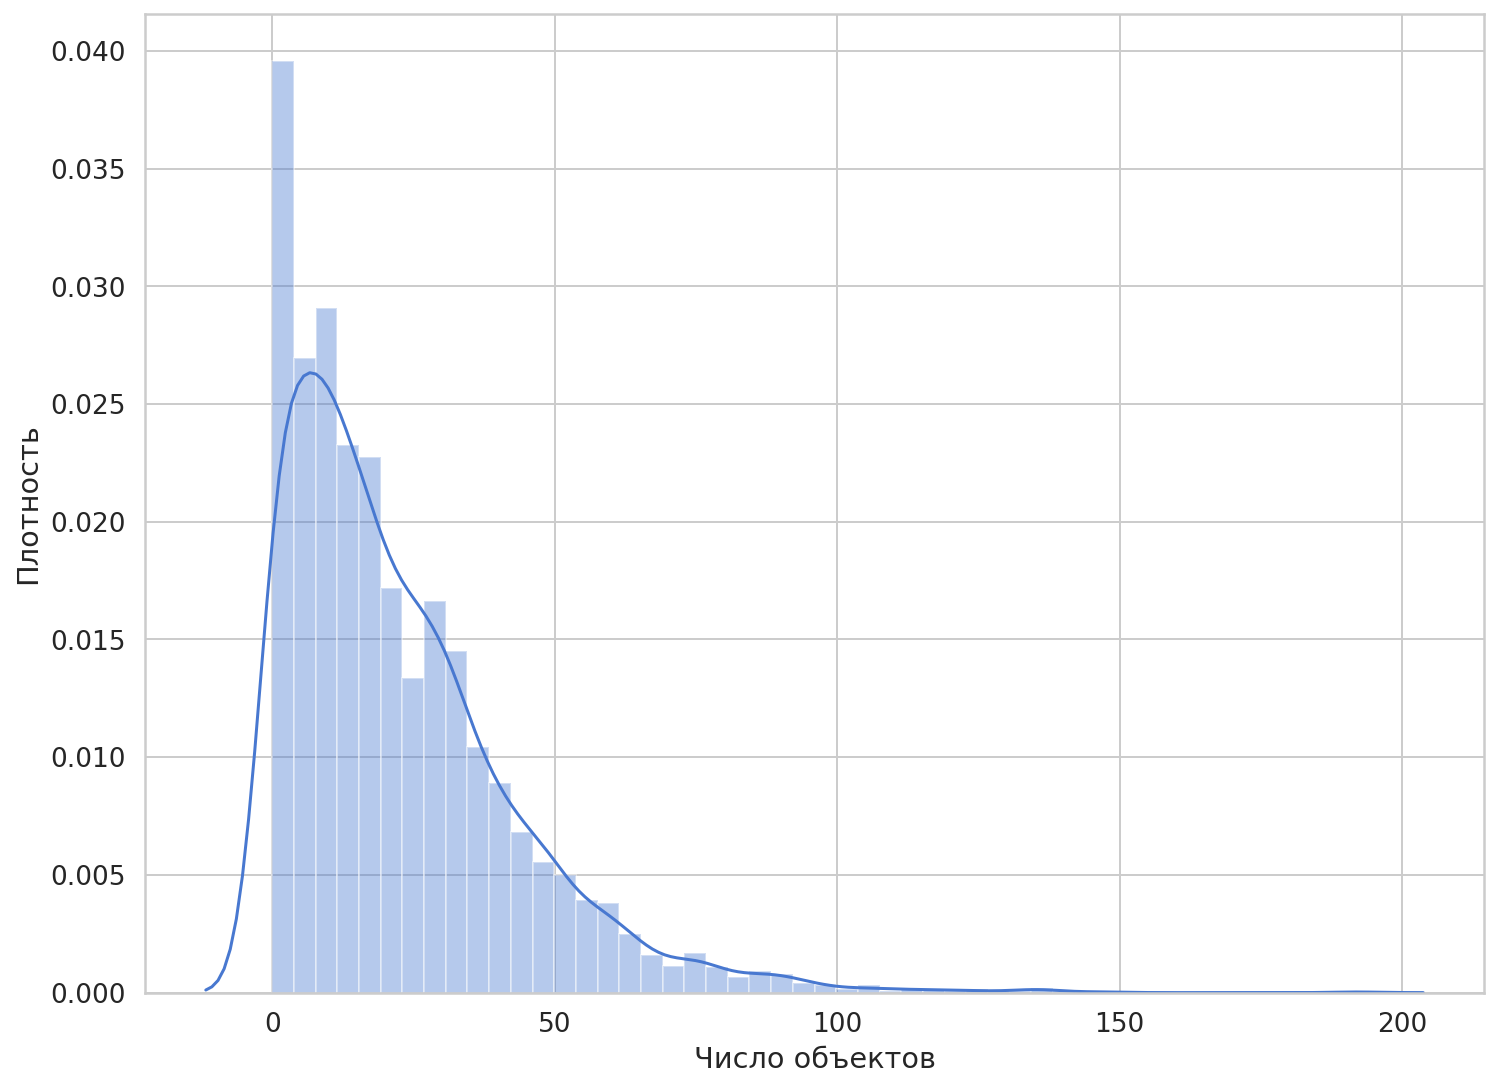

In [26]:
sns.distplot(np.array(lens))
plt.xlabel('Число объектов')
plt.ylabel('Плотность')
plt.savefig('den_only_heic.jpg', bbox_inches="tight")
plt.show()

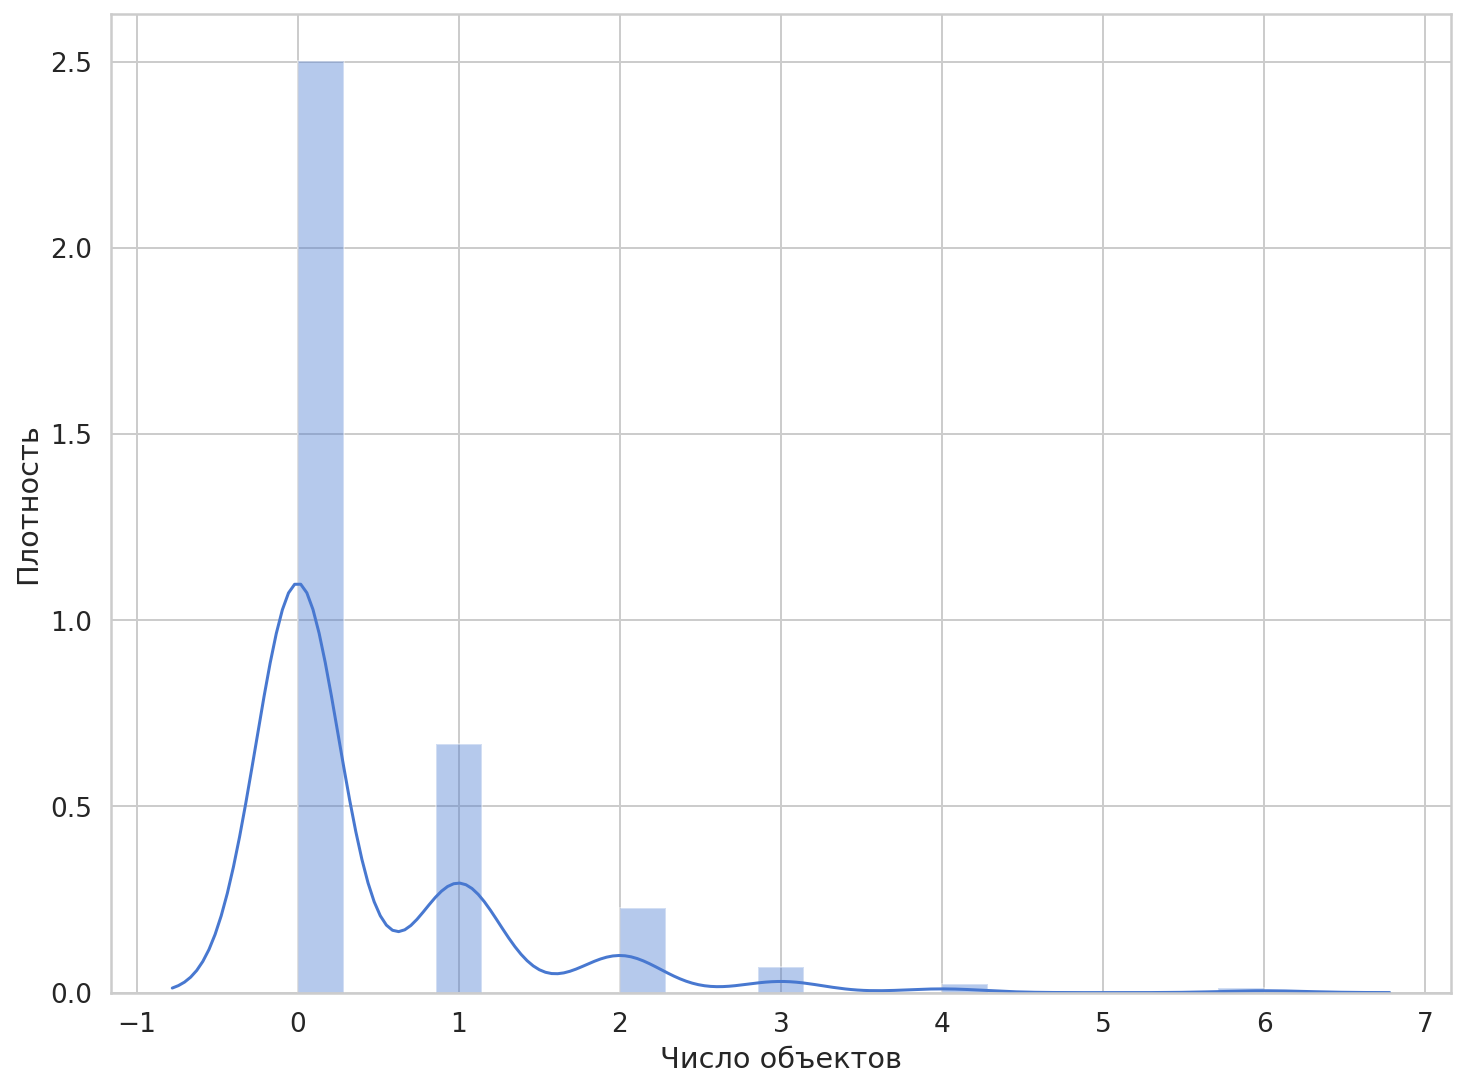

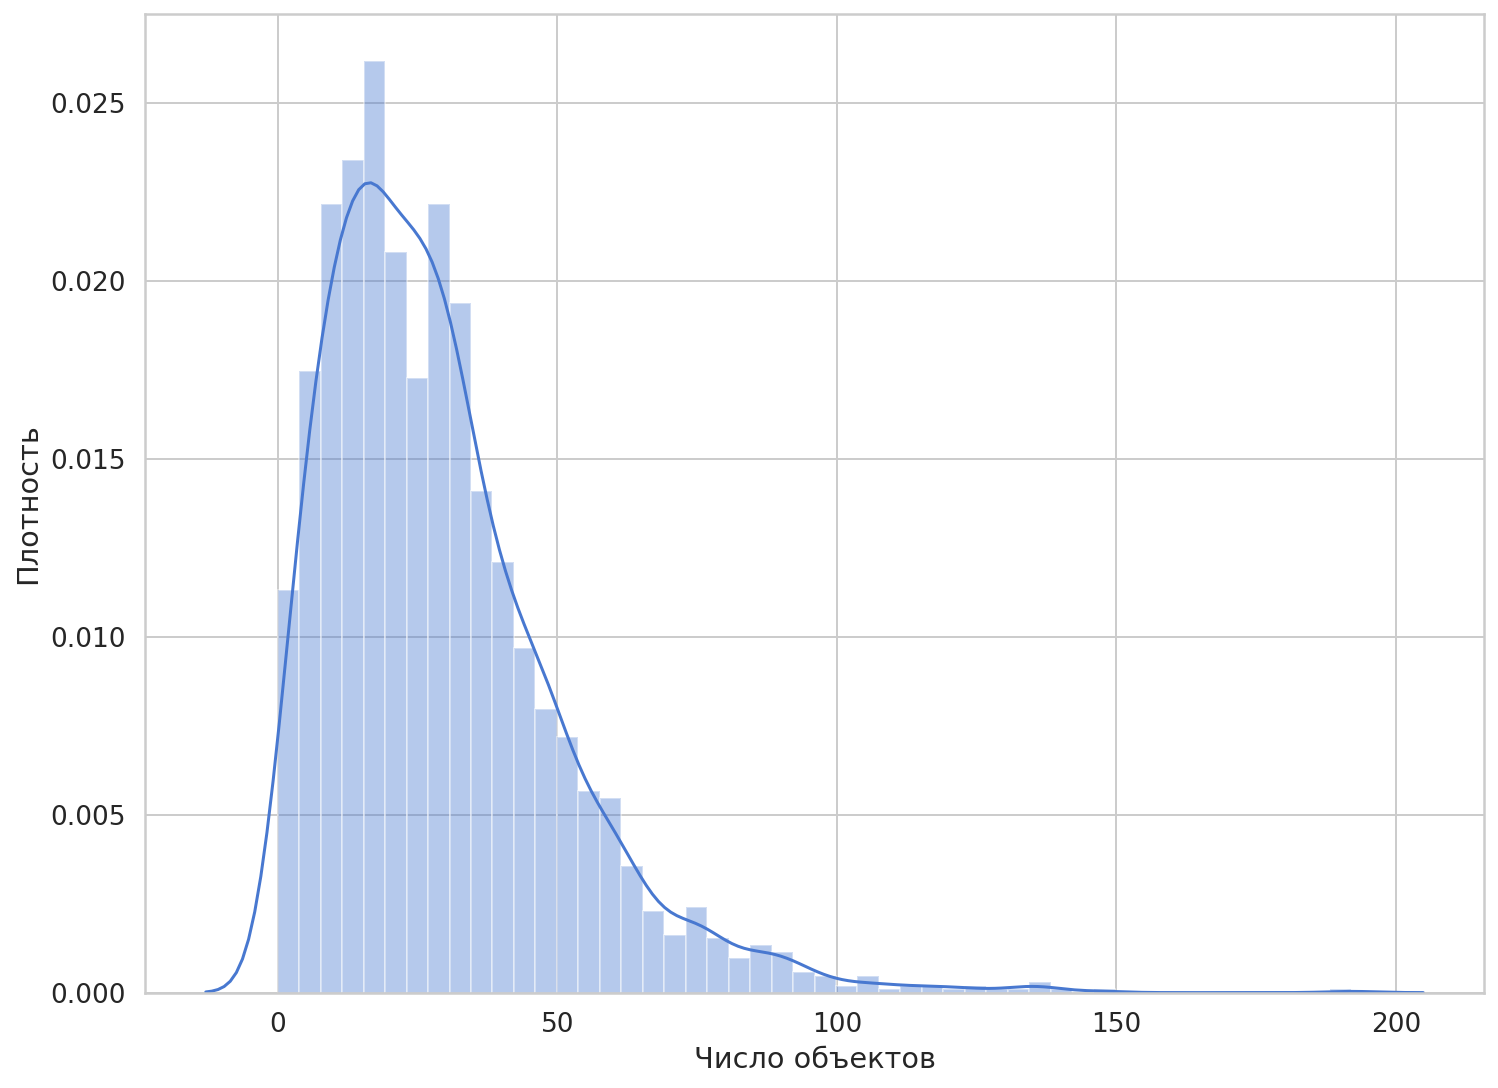

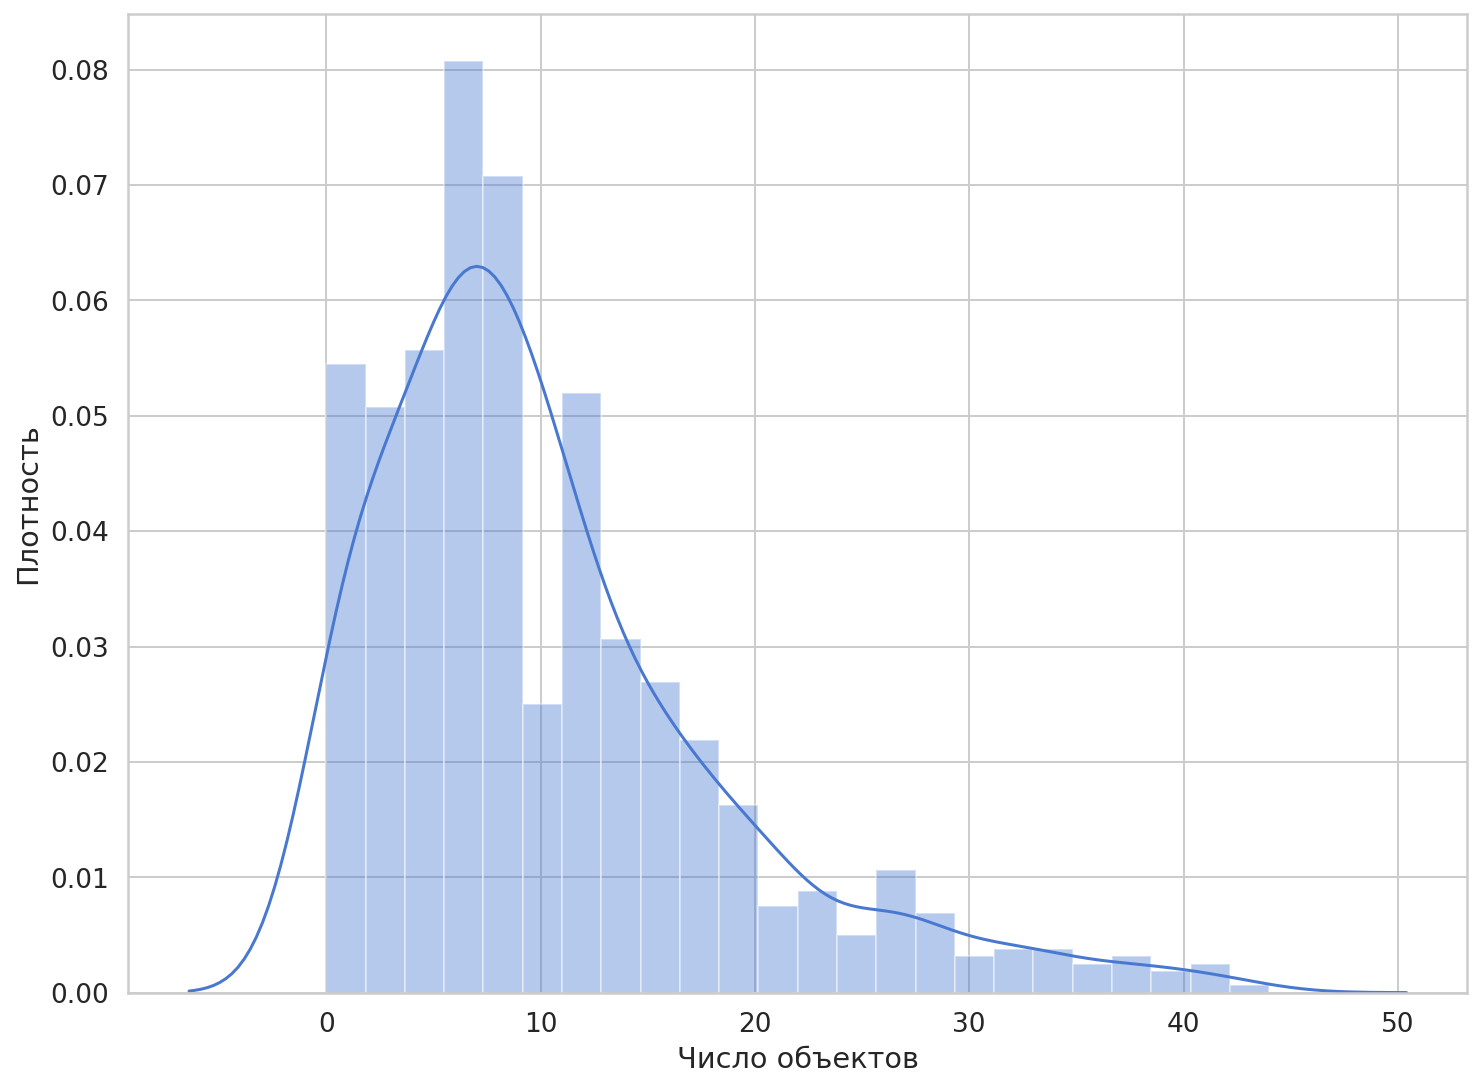

In [27]:
sns.distplot((np.array(lens))[:len(class_0_imgs)])
plt.xlabel('Число объектов')
plt.ylabel('Плотность')
plt.savefig('den_only_heic_0.jpg', bbox_inches="tight")
plt.show()

sns.distplot((np.array(lens))[len(class_0_imgs):len(class_0_imgs)+len(class_1_imgs)])
plt.xlabel('Число объектов')
plt.ylabel('Плотность')
plt.savefig('den_only_heic_1.jpg', bbox_inches="tight")
plt.show()

sns.distplot((np.array(lens))[len(class_0_imgs)+len(class_1_imgs):])
plt.xlabel('Число объектов')
plt.ylabel('Плотность')
plt.savefig('den_only_heic_2.jpg', bbox_inches="tight")
plt.show()

In [28]:
# собираем все предсказания в один массив

X = []
for preds_per_class in preds_all:
    X += preds_per_class
y = np.array([0] * len(class_0_imgs) + [1] * len(class_1_imgs) + [2] * len(class_2_imgs))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [30]:
len(X), len(y)

(3895, 3895)

In [31]:
# max_len - количество учитываемых предсказанных рамок для одной фотографии (самых вероятных)
# убираем координаты рамок, дополняем недостающие предсказания 0

class MyDataset(Dataset):
    def __init__(self, x, y, max_len):
        self.x = x
        lens = []
        for i in range(len(self.x)):
            if self.x[i].shape[0]:
                self.x[i] = self.x[i][:, 4:]
            else:
                self.x[i].reshape((0, 2))
            conf = self.x[i][:, 0]
            argsort = torch.argsort(conf, dim=0, descending=True)
            self.x[i] = self.x[i].flatten()[: max_len * 2].tolist()
            self.x[i] += [0.] * (max_len * 2 - len(self.x[i])) + [len(self.x[i])]
            
        self.y = y.reshape((y.shape[0], 1))
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)

In [32]:
BATCH_SIZE = 200

max_len = 50

train_dataset = MyDataset(X_train, y_train, max_len)
test_dataset = MyDataset(X_test, y_test, max_len)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
           nn.Linear(max_len * 2 + 1, 200),
           nn.ReLU(),
           nn.Linear(200, 150),
           nn.ReLU(),
           nn.Linear(150, 3),
        )
    def forward(self, x):
        return self.linear(x)

In [34]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Net()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([y.shape[0] / (y==0).sum(), y.shape[0] / (y==1).sum(), y.shape[0] / (y==2).sum()], dtype=torch.float).to(device))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

In [35]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = (12, 9)

def plot_losses(losses_train, losses_test):
    clear_output()
    plt.plot(range(1, len(losses_train) + 1), losses_train, label='train')
    plt.plot(range(1, len(losses_test) + 1), losses_test, label='test')
    plt.title('изменение качества при обучении', fontsize=14)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend()
    plt.show()

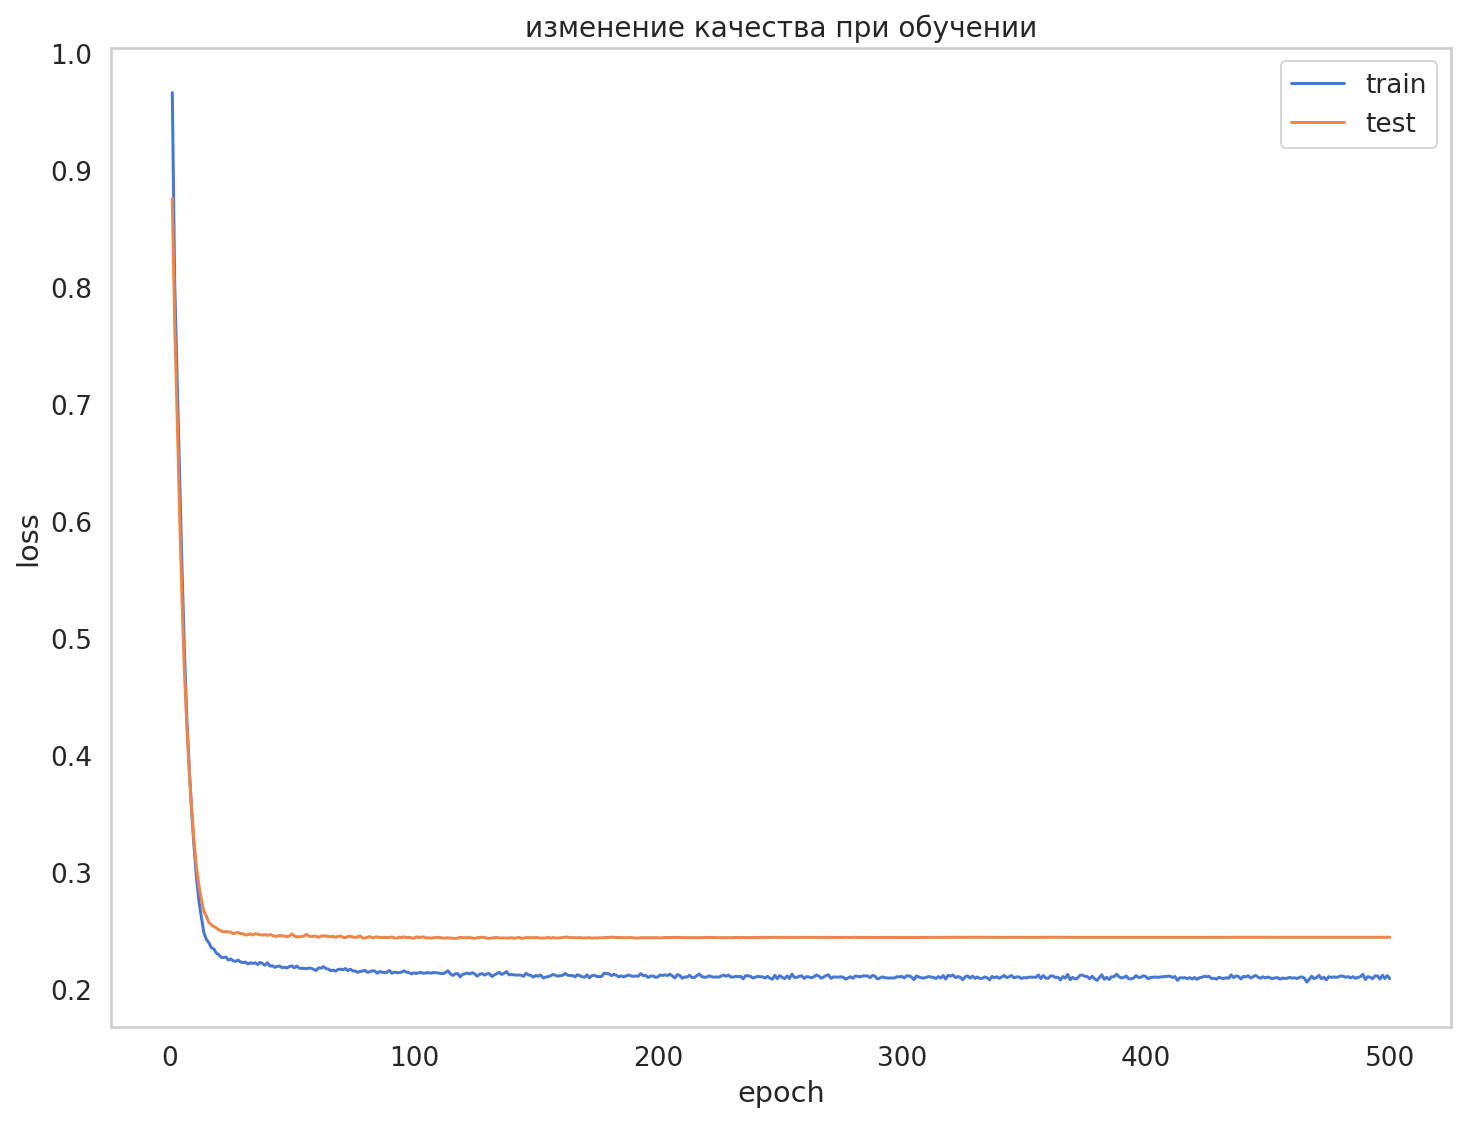

In [36]:
NUM_EPOCHS = 500
losses_train, losses_test = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    running_loss_train, running_loss_test = 0.0, 0.0
    model.train()
    for x, y in tqdm(train_dataloader):
        
        x = x.to(device)
        y = y.type(torch.LongTensor).squeeze(1).to(device)
        optimizer.zero_grad()
        logits = model(x)
        
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss_train += loss.item() * y.shape[0]
    
    losses_train += [running_loss_train / len(train_dataset)]

    model.eval()
    for x, y in tqdm(test_dataloader):
        with torch.no_grad():
            
            x = x.to(device)
            y = y.type(torch.LongTensor).to(device).squeeze(1)

            logits = model(x)

            loss = criterion(logits, y)
            running_loss_test += loss.item() * y.shape[0]
    
    losses_test += [running_loss_test / len(test_dataset)]
    
    plot_losses(losses_train, losses_test)

In [37]:
from IPython.display import display
from time import time

num_matches = 0
model.eval()
for x, y in tqdm(test_dataloader):
    with torch.no_grad():
            
        x = x.to(device)
        y = y.type(torch.LongTensor).squeeze(1)
        logits = model(x).cpu()
        num_matches += (np.argmax(logits, 1) == y).sum()
        
        
print('test accuracy = ', num_matches / len(test_dataset))

num_matches = 0
model.eval()
for x, y in tqdm(train_dataloader):
    with torch.no_grad():
            
        x = x.to(device)
        y = y.type(torch.LongTensor).squeeze(1)
        logits = model(x).cpu()
        num_matches += (np.argmax(logits, 1) == y).sum()
print('')
print('train accuracy = ', num_matches / len(train_dataset))

100%|██████████| 6/6 [00:00<00:00, 16.60it/s]


test accuracy =  tensor(0.93328)


100%|██████████| 14/14 [00:00<00:00, 37.26it/s]


train accuracy =  tensor(0.94204)


In [38]:
# сохранение весов

torch.save(model, 'model_params.pt')